In [1]:
import cv2
import numpy as np
import os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from matplotlib import pyplot as plt
import keras

cat_dir = 'cat_images/'
dog_dir = 'dog_images/'
SIZE = (256, 256)
TRAIN_RATIO = 0.7
RESHAPED = 0
NB_CLASSES = 2
OPTIMIZER = SGD()
BATCH_SIZE = 20
NB_EPOCH = 50
VALIDATION_SPLIT = 0.2
VERBOSE = 1
def prepare_data():
    # 猫(0)と犬(1)の画像を取得してフラグを追加したにシャッフル加工してデータとして返す。
    
    images = []
    answers = []
    cat_images = os.listdir(cat_dir)
    for cat_image in cat_images:
        if cat_image.endswith('.jpg'):
            images.append(resize_for_model(cv2.imread(cat_dir + cat_image)))
            answers.append(0)
    dog_images = os.listdir(dog_dir)
    for dog_image in dog_images:
        if dog_image.endswith('.jpg'):
            images.append(resize_for_model(cv2.imread(dog_dir + dog_image)))
            answers.append(1)
    
    images = np.array(images)
    answers = np.array(answers)
    # imagesとanswersの関係保ったままシャッフル
    random_idxs = np.random.permutation(len(images))
    images = images[random_idxs]
    answers = answers[random_idxs]
    # train_data, test_dataに分ける
    border = int(len(images) * TRAIN_RATIO)
    
    return (images[:border], answers[:border]), (images[border:], answers[border:])

def resize_for_model(image):
    # np形式のimageを特定の大きさにresizeする。
    return cv2.resize(image, SIZE)

if __name__ == '__main__':
    (X_train, y_train), (X_test, y_test) = prepare_data()
    print(len(X_train), 'X_train amount')
    print(len(X_test), 'X_test amount')
    print(X_train.shape, 'X_train shape')
    print(X_test.shape, 'X_test shape')
    SHAPE = (X_train.shape[1], X_train.shape[2], X_train.shape[3])


Using TensorFlow backend.


140 X_train amount
60 X_test amount
(140, 256, 256, 3) X_train shape
(60, 256, 256, 3) X_test shape


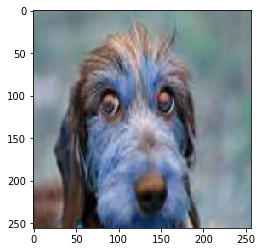

1


In [2]:
# debug
idx = 3
plt.imshow(X_train[idx])
plt.show()
print(y_train[idx])

In [3]:
# X_train = X_train.reshape(140, RESHAPED)
# X_test = X_test.reshape(60, RESHAPED)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

In [4]:
Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
Y_test = np_utils.to_categorical(y_test, NB_CLASSES)


In [5]:
# model = Sequential()
# model.add(Dense(1, input_shape=(RESHAPED,))) #Dense引数1つ目は出力数
# # model.add(Dense(16))
# # model.add(Dense(2))
# model.add(Activation('relu'))
# model.summary()

In [6]:
#参考: https://keras.io/getting-started/sequential-model-guide/
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=SHAPE))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NB_CLASSES, activation='softmax'))

In [7]:
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

In [8]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Train on 112 samples, validate on 28 samples
Epoch 1/50
112/112 [==============================] - 29s 255ms/step - loss: 7.9277 - acc: 0.5000 - val_loss: 9.7326 - val_acc: 0.3929
Epoch 2/50
112/112 [==============================] - 27s 241ms/step - loss: 8.4445 - acc: 0.4732 - val_loss: 9.7326 - val_acc: 0.3929
Epoch 3/50
112/112 [==============================] - 27s 241ms/step - loss: 8.4445 - acc: 0.4732 - val_loss: 9.7326 - val_acc: 0.3929
Epoch 4/50
112/112 [==============================] - 27s 245ms/step - loss: 8.4445 - acc: 0.4732 - val_loss: 9.7326 - val_acc: 0.3929
Epoch 5/50


KeyboardInterrupt: 

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print('Test score:', score[0])
print('Test acc:', score[1])